<H1>10,000 USD worth of INTR invested in the Omnipool for 4 months</H1>

In [11]:
import sys
import os
import glob
import random
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, usd_price, lrna_price
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)
price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 120)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.20},
    'BTC': {'usd price': price_list[0]['BTC'], 'weight': 0.10},
    'ETH': {'usd price': price_list[0]['ETH'], 'weight': 0.40},
    'INTR': {'usd price': price_list[0]['DOT'], 'weight': 0.20}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            asset_fee=0,
            lrna_fee=0
        )
    },
    agents = {
        'Trader': Agent(
            holdings={tkn: 10000000 for tkn in assets},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool'
            )
        ),
        'LP': Agent(
            holdings={'INTR': 10000 / price_list[0]['DOT']},
            trade_strategy=invest_all('omnipool')
        )
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    archive_all=False
)
time_steps = len(price_list)-1
# print(f'Running with {time_steps} time steps')
# events = run.run(initial_state, time_steps=time_steps)
# events = processing.postprocessing(events, optional_params=['withdraw_val'])

In [7]:
price_path = []
modifier_list = [-0.5, -0.25, 0, 0.25, 0.5]
colors = pu.color_gradient(length=5, color1=(255, 0, 0), color2 = (0, 255, 0))
initial_dot_price = price_list[0]['DOT']

for i, price_shift in enumerate(modifier_list):
    price_shift_per_block = price_shift / time_steps
    price_path.append([
        {('INTR' if tkn == 'DOT' else tkn): (
            price * (1 + i * price_shift_per_block)
            if tkn == 'DOT' else price
        )
        for tkn, price in assets.items()}
        for i, assets in enumerate(price_list)
    ])

<h3>Effect of price change on LP returns.</h3> We'll simulate the returns for an LP over the course of four months under a variety of market conditions. We'll see that large price changes - even positive ones - are not best for LPs.

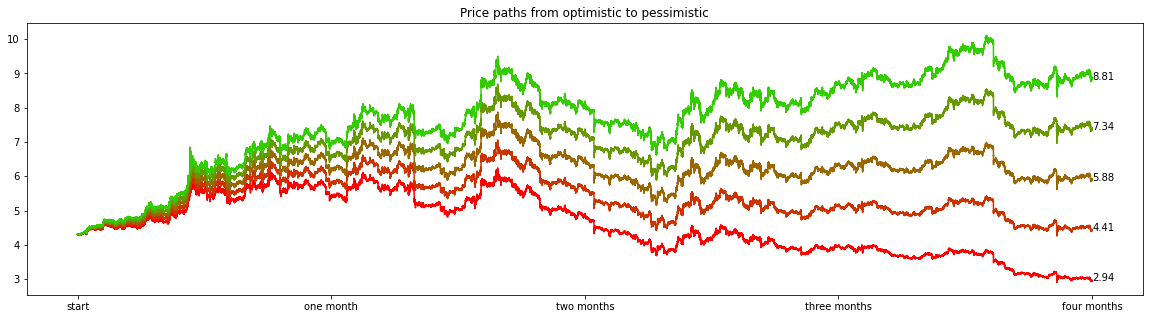

In [28]:
intr_prices = [[step["INTR"] for step in path] for path in price_path]
plt.figure(figsize=(20, 5))
plt.title("Price paths from optimistic to pessimistic")
graph_length = len(intr_prices[1])
plt.xticks(
    [0, graph_length / 4, graph_length / 2, graph_length * 3/4, graph_length],
    ['start', 'one month', 'two months', 'three months', 'four months']
)

for i in range(len(intr_prices)):
    plt.plot(range(len(intr_prices[i])), intr_prices[i], color=colors[i])
    plt.annotate(str(round(intr_prices[i][-1], 2)), xy=(len(intr_prices[i]), intr_prices[i][-1]), xytext=(0,0), textcoords='offset points')


In [8]:
returns = []
price_events = []
plt.figure(figsize=(20, 5))
for i, scenario in enumerate(price_path):
    initial_state._evolve_function = historical_prices(scenario)
    random.seed(42)
    events = run.run(initial_state, time_steps)
    price_events.append(events[::200])
    returns.append([cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in price_events[i]])
#     plt.plot(range(len(intr_prices[i])), intr_prices[i], color=colors[i])
#     plt.annotate(str(round(intr_prices[i][-1] * 10000, 2)), xy=(time_steps, intr_prices[-1]), xytext=(30,0), textcoords='offset points')
    
print('Trade volume per day as a fraction of TVL:', 
    sum([sum([event.pools['omnipool'].volume_in[tkn] * event.external_market[tkn] for tkn in assets]) for event in events])
    / time_steps / 10000000 * 7200
)

Starting simulation...
Execution time: 133.801 seconds.
Starting simulation...
Execution time: 225.149 seconds.
Starting simulation...
Execution time: 270.97 seconds.
Starting simulation...
Execution time: 507.628 seconds.
Starting simulation...
Execution time: 382.83 seconds.
Trade volume per day as a fraction of TVL: 0.3407088455169722


<Figure size 1440x360 with 0 Axes>

<H3>Comparison with LRNA price</H3>
Impermanent loss is related not to the absolute price change as such, but to the change in price relative to the price of LRNA. In other words, IL for each price path is correlated to its distance from the black line (LRNA price) in this graph.

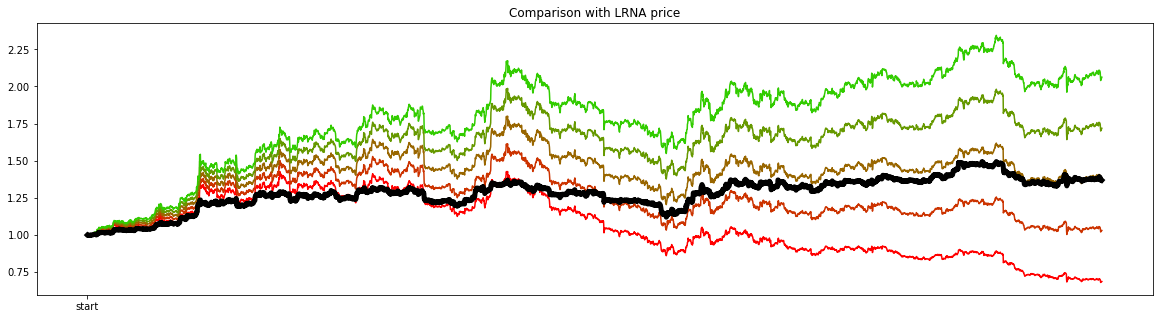

In [29]:
plt.figure(figsize=(20, 5))
plt.title("Comparison with LRNA price")
graph_length = len(intr_prices[1])
plt.xticks(
    [0, graph_length / 4, graph_length / 2, graph_length * 3/4, graph_length],
    ['start', 'one month', 'two months', 'three months', 'four months']
)

for i in range(len(intr_prices)):
    plt.plot(range(len(intr_prices[i][::200])), [price / initial_dot_price for price in intr_prices[i][::200]], color=colors[i])
    # plt.annotate(
    #     str(round(intr_prices[i][-1], 2)), 
    #     xy=(len(intr_prices[i]), intr_prices[i][-1] / initial_dot_price), 
    #     xytext=(0,0), textcoords='offset points'
    # )
    
plt.plot(range(len(price_events[2])), [1 / lrna_price(event.pools['omnipool'], 'USD') / lrna_price_usd for event in price_events[2]], color='black', linewidth=5)

<h3>Results from the preceeding simulations.</h3> Note that due to impermanent loss, the middle price paths where there is little change from beginning to end fare best. Also note that it's the price change <i>relative to the rest of the assets in the pool</i> that matters... during this run, it's the middle path where the price of INTR most closely follows the gains experienced by the rest of the pool, and thus suffers the least impermanent loss.

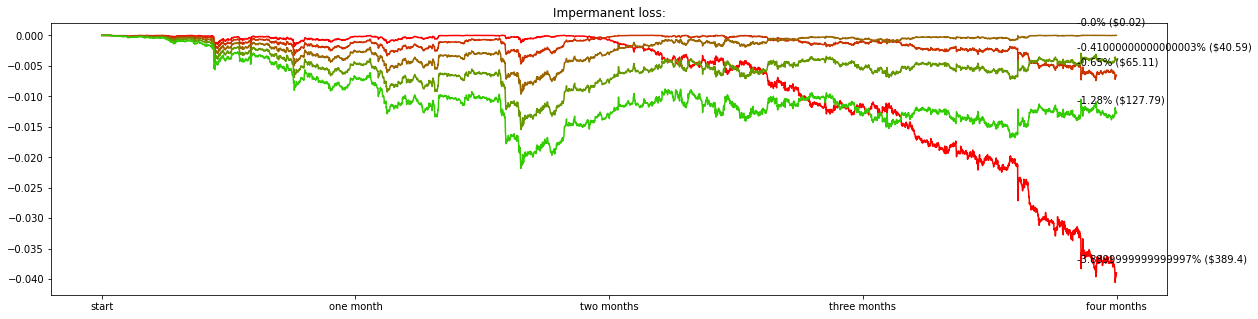

In [26]:
plt.figure(figsize=(20, 5))
plt.title('Impermanent loss:')
graph_length = len(returns[1])
plt.xticks(
    [0, graph_length / 4, graph_length / 2, graph_length * 3/4, graph_length],
    ['start', 'one month', 'two months', 'three months', 'four months']
)

initial_holdings = initial_state.agents['LP'].holdings['INTR']
for i, scenario in enumerate(returns):
    il = [
        scenario[j] / initial_holdings / price_events[i][j].external_market['INTR'] - 1 
        for j, step in enumerate(scenario)
    ]
    plt.plot(
        range(len(scenario)), il, color=colors[i]
    )
    plt.annotate(
        f'{round(il[-1], 4) * 100}% (${abs(round(il[-1] * 10000, 2))})',
        xy=(len(scenario), il[-1]), xytext=(-40, 10), textcoords='offset points'
    )
# plt.plot([0, len(returns[0])], [baseline, baseline], color='black', linewidth=5)